# CatBOOST模型

## CatBOOST模型原理介绍

**CatBoost（Categorical Boosting）**是一种基于梯度提升决策树（GBDT）的机器学习算法，专为处理分类特征和高效建模而设计。它在结构和性能上与其他GBDT框架（如XGBoost、LightGBM）类似，但在处理分类特征、防止过拟合和训练速度上有显著改进

## CatBOOST模型核心技术

### Ordered Boosting（有序提升）

传统梯度提升决策树在计算目标编码时容易造成**数据泄露**问题（即训练数据中的目标变量可能对特征计算造成不合理影响）。CatBoost使用了一种随机排列的技术：
1. 将数据随机排列。
2. 对于每一行，只使用排列顺序中前面的行计算目标编码值，从而避免了数据泄露问题。

### 对称树（Symmetric Tree）

与XGBoost和LightGBM不同，CatBoost构造的是**对称树**： 
  - 所有决策树的每一层都在所有数据上使用相同的分裂条件。
  - 优势： 
      - **训练速度更快**： 分裂条件只需要计算一次。
      - **预测速度更快**： 在预测时只需按树的对称路径遍历即可。
      - **鲁棒性更高**： 在小数据集上表现更稳定。

### 高效目标编码（Efficient Target Encoding）

对于分类特征，CatBoost将其转换为数值特征时，使用了**Ordered Target Encoding**方法： 
  - 通过分批处理或数据折叠来确保训练数据和目标编码之间相互独立，避免数据泄露。
  - 目标编码支持**分类特征高基数**（如一个特征有上千个不同类别）。

### 内置文本处理

CatBoost内置文本特征预处理方法，如TF-IDF、文本嵌入等，可以直接对文本特征进行建模。避免了手动设计特征的复杂过程。

# CatBOOST模型优缺点

## CatBOOST模型优点

- **强大的分类特征处理能力**：无需对类别特征手动编码，减少特征工程的复杂性
- **防止数据泄露**：Ordered Boosting和目标编码方法避免了常见的信息泄露问题

## CatBOOST模型缺点

- **对超大数据集的内存需求较高**：与LightGBM相比，内存使用效率稍差
- **训练速度比LightGBM慢**：尽管比XGBoost快，但在纯数值特征数据集上仍不及LightGBM

# CatBoost模型案例（分类）

## CatBoostClassifier

- **iterations**：决策树的数量（迭代次数）
    - 增加iterations会提高模型的表现效果，但是iterations设置过大也会导致过拟合
- **learning_rate**：学习率，控制每棵树的权重
    - learning_rate越小，则每棵树对最终决策的影响越低，模型更稳健，但是同时也需要更多的树来提升性能
- **depth**：树的最大深度，默认6
- **loss_function**：损失函数
    - `Logloss`：二分类
    - `MultiClass`：多分类
    - `RMSE`：均方根误差（Root Mean Square Error），默认损失函数
    - `MAE`：平均绝对误差（Mean Absolute Error）
    - `MAPE`：平均绝对百分比误差（Mean Absolute Percentage Error）
- **random_seed**：随机数种子，确保实验可复现
- **l2_leaf_reg**：L2正则化系数，默认3，防止过拟合。
- **early_stopping_rounds**：早停系数。
- **cat_features**：指定类别特征。
- **embedding_features**：指定嵌入特征。
- **text_features**：指定文本特征列，自动进行NLP处理。
- **class_weights**：类别权重，处理不平衡数据。
- **classes_count**：分类类别数量（多分类时用）。
- **border_count**：连续特征分箱时的最大分箱数。

## 泰坦尼克数据集

**titanic 数据集**包含了 891 条乘客记录，每条记录描述了乘客的个人信息及其在 Titanic 号上的生存情况
- survived：生存情况（0 = 未生还, 1 = 生还）
- pclass：乘客舱等级（1 = 一等舱, 2 = 二等舱, 3 = 三等舱）
- sex：乘客性别（male = 男性, female = 女性）
- age：乘客年龄（float，部分缺失值）
- sibsp：乘客在船上的兄弟姐妹或配偶数量（整数）
- parch：乘客在船上的父母或子女数量（整数）
- fare：乘客支付的票价（float）
- embarked：乘客登船港口（C = 瑟堡, Q = 皇后镇, S = 南安普敦）
- class：舱等级（文本版本的 pclass，First = 头等舱, Second = 二等舱, Third = 三等舱）
- who：乘客身份（man = 成年男性, woman = 成年女性, child = 儿童）
- adult_male：是否为成年男性（True = 是, False = 否）
- deck：乘客所在的甲板（A, B, C, D, E, F, G，部分缺失值较多）
- embark_town：乘客登船的城市（Cherbourg = 瑟堡, Queenstown = 皇后镇, Southampton = 南安普敦）
- alone：是否独自旅行（True = 独自旅行，False = 有亲属同行，对应 sibsp + parch == 0）

In [5]:
# 导入必要的库
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                           classification_report, roc_curve, auc)
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# 加载seaborn内置的泰坦尼克数据集
df = sns.load_dataset('titanic')

# 填充 'age' 列的缺失值：使用该列的中位数填充缺失值
df['age'].fillna(df['age'].median(), inplace=True)
# 填充 'embarked' 列的缺失值：使用该列的众数填充缺失值
df['embarked'].fillna(df['embarked'].mode()[0], inplace=True)
# 将 'sex' 列转化为数值：'male' 映射为 1，'female' 映射为 0
df['sex'] = df['sex'].map({'male': 1, 'female': 0})
# 将 'embarked' 列转化为数值：'C' 映射为 0，'Q' 映射为 1，'S' 映射为 2
df['embarked'] = df['embarked'].map({'C': 0, 'Q': 1, 'S': 2})

df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,1,22.0,1,0,7.2500,2,Third,man,True,NaN,Southampton,no,False
1,1,1,0,38.0,1,0,71.2833,0,First,woman,False,C,Cherbourg,yes,False
2,1,3,0,26.0,0,0,7.9250,2,Third,woman,False,NaN,Southampton,yes,True
3,1,1,0,35.0,1,0,53.1000,2,First,woman,False,C,Southampton,yes,False
4,0,3,1,35.0,0,0,8.0500,2,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,27.0,0,0,13.0000,2,Second,man,True,NaN,Southampton,no,True
887,1,1,0,19.0,0,0,30.0000,2,First,woman,False,B,Southampton,yes,True
888,0,3,0,28.0,1,2,23.4500,2,Third,woman,False,NaN,Southampton,no,False
889,1,1,1,26.0,0,0,30.0000,0,First,man,True,C,Cherbourg,yes,True


## 代码实现

0:	test: 0.8374517	best: 0.8374517 (0)	total: 18.8ms	remaining: 9.36s
20:	test: 0.8829472	best: 0.8835264 (15)	total: 53.8ms	remaining: 1.23s
40:	test: 0.8866795	best: 0.8892535 (32)	total: 82.5ms	remaining: 924ms
60:	test: 0.8898970	best: 0.8913127 (47)	total: 112ms	remaining: 804ms
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8913127413
bestIteration = 47

Shrink model to first 48 iterations.


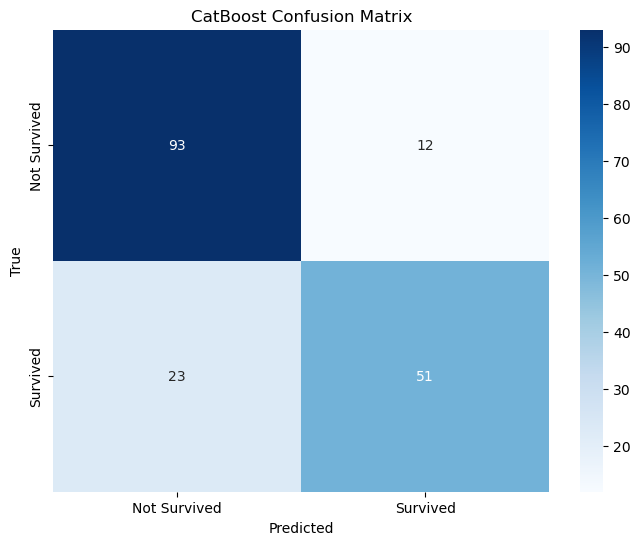

Classification Report:
              precision    recall  f1-score   support

           0     0.8017    0.8857    0.8416       105
           1     0.8095    0.6892    0.7445        74

    accuracy                         0.8045       179
   macro avg     0.8056    0.7875    0.7931       179
weighted avg     0.8049    0.8045    0.8015       179



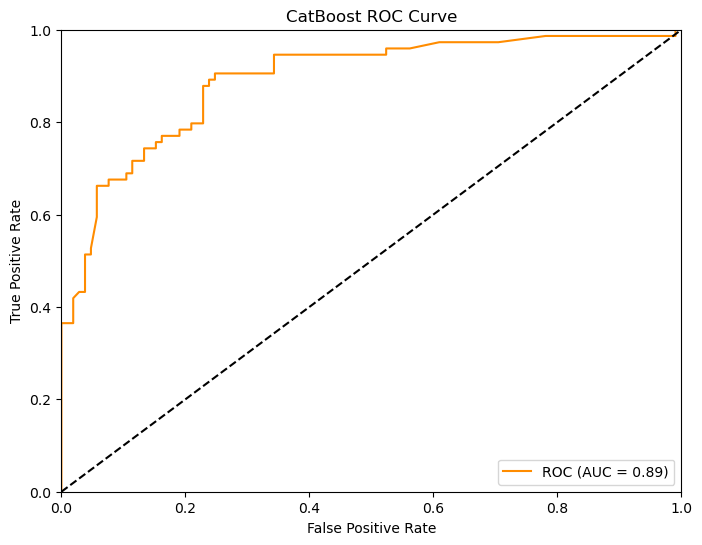

In [6]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns

# 特征与目标列
features = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']
X = df[features].dropna()
y = df.loc[X.index, 'survived']  # 确保 y 与 X 对齐

# 划分训练验证集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 指定类别特征列（列名或列索引）
cat_features = ['sex', 'embarked']

# 初始化 CatBoostClassifier
cat_clf = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    cat_features=cat_features,
    random_seed=42,
    verbose=0  # 关闭训练输出
)

# 训练模型（直接传 DataFrame 和 cat_features）
cat_clf.fit(X_train, 
            y_train, 
            eval_set=(X_test, y_test),
            verbose=20,
            early_stopping_rounds=20)

# 模型评估
y_probs = cat_clf.predict_proba(X_test)[:, 1]
y_pred = cat_clf.predict(X_test)

# 1. 混淆矩阵
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Survived", "Survived"], 
            yticklabels=["Not Survived", "Survived"])
plt.title("CatBoost Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 2. 分类报告
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

# 3. ROC 曲线
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CatBoost ROC Curve')
plt.legend(loc="lower right")
plt.show()

# CatBoost模型可视化

## Pool: 是 CatBoost 中用来封装数据的一个类，用于训练、验证和预测。
- `data`: 输入数据
- `label`: 目标值
- `cat_features`: 指定类别特征
- `text_features`: 指定文本特征
- `embedding_features`: 指定嵌入特征

## cat_clf.plot_tree: CatBoost模型可视化
- `tree_idx`: 要可视化的树的索引（从 0 开始）
- `pool`: 训练数据池。如果模型包含类别型特征（cat_features），必须提供 pool

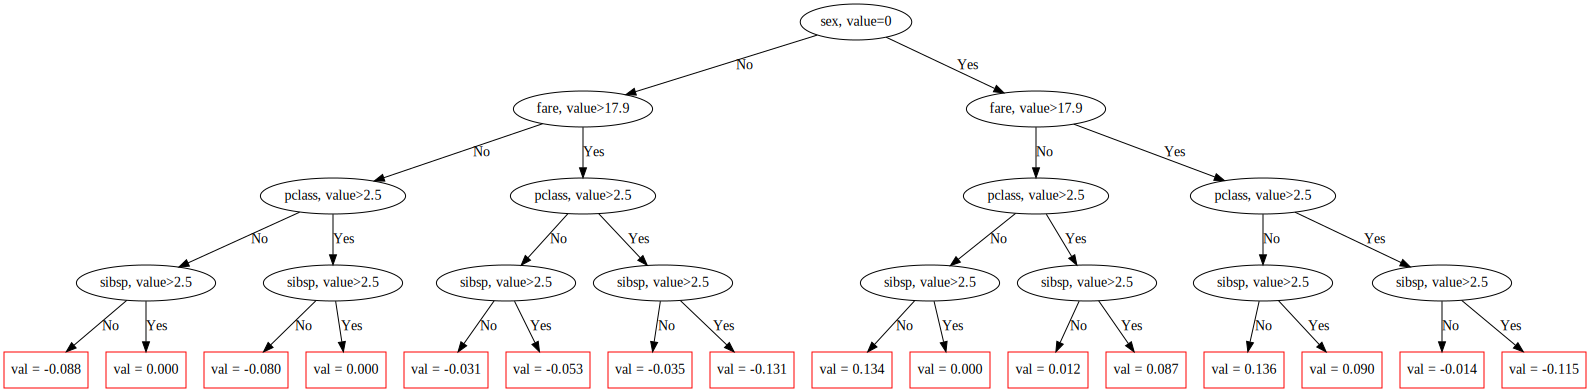

In [7]:
# 创建 CatBoost 专用的 Pool 数据容器对象
# Pool 是 CatBoost 高效处理数据的特殊数据结构，比普通 numpy/pandas 更能优化内存和计算效率
train_pool = Pool(
    data=X_train,          # 训练集特征数据 (DataFrame 或 numpy array)
    label=y_train,         # 对应的目标标签 (Series 或 numpy array)
    cat_features=cat_features  # 指定哪些列是类别型特征（列名列表或列索引列表）
)

# 可视化 CatBoost 模型中的决策树
cat_clf.plot_tree(
    tree_idx=3,            # 要可视化的树索引（从0开始）
    pool=train_pool,       # 提供训练数据 Pool（必须包含类别特征信息），这是显示类别特征分割点所必需的
)

# 特征重要度

**特征重要性（feature importance）是 CatBoost 模型中用于衡量各个特征对预测结果贡献程度的指标。**

* 在 CatBoost 中，模型是通过梯度提升方法（Gradient Boosting）加权多个对称决策树组成的。

* 每棵树在训练过程中，会在某些特征上进行分裂，每次分裂都会带来模型损失函数的下降（如目标函数的梯度平方和减少）。

* CatBoost 中每个节点的分裂增益代表了该特征对整体模型性能的贡献。

* 因此，一个特征在多个树的“重要分裂节点”中频繁被使用，其最终特征重要性越高。

* 计算公式为：

$$
\text{Importance}_j = \sum_{m=1}^{M} \sum_{t \in T_m} \Delta \text{Gain}_t \cdot \mathbb{1}(j \in t)
$$

其中：

* \$M\$：CatBoost 中树的数量

* \$T\_m\$：第 \$m\$ 棵树中的所有非叶子分裂节点

* \$\Delta \text{Gain}\_t\$：节点 \$t\$ 分裂带来的目标函数下降量（增益）

* \$\mathbb{1}(j \in t)\$：若节点 \$t\$ 使用特征 \$j\$ 进行分裂，则为 1，否则为 0

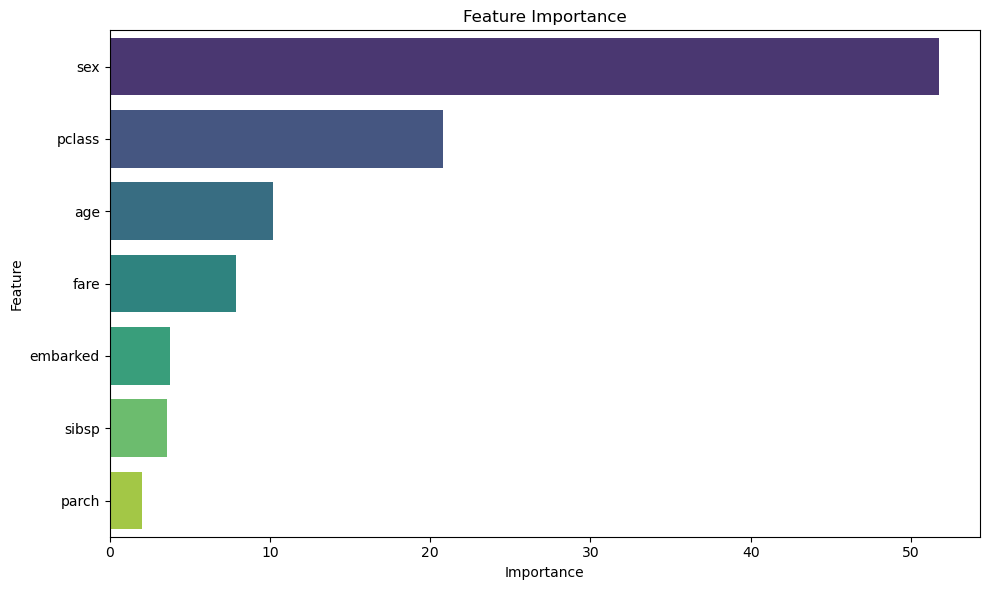

In [8]:
# 特征重要性
feature_imp = pd.DataFrame({
    'Feature': X.columns,
    'Importance': cat_clf.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_imp, palette='viridis')
plt.title("Feature Importance")
plt.tight_layout()
plt.show()